In [1]:
import os
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from adad.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent.parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


## Objective

Create Cumulative Accuracy (CA) plots per dataset per model;

## Cumulative Accuracy (CA) Plot

- First, sort samples based on the Applicability Domain measures;
- Based on the ranking, including the top n% of samples, and calculating the 
accuracy of the subset;
- Gradually increase the sample size until all samples are included;
- The accuracy on the far right is computed based on 100% of samples, which is
equivalent to no applicability domain is applied.
- The worst case is a horizontal line, which indicates the AD cannot distinguish 
reliable and unreliable predictions.
- X axis: Compound (%)
- Y axis: Cumulative Accuracy (%)
- X starts from 2%;

In [3]:
# Constants
CLASSIFIERS = ['KNeighborsClassifier', 'NNClassifier', 'RandomForestClassifier', 'SVC']
CLF_alias = ['KNN', 'NN', 'RF', 'SVM']
AD = ['DAIndexDelta', 
      'DAIndexGamma', 
      'DAIndexKappa', 
      'PCABoundingBox', 
      'ProbabilityClassifier', 
      'Magnet',
      'SklearnFeatureSqueezing', 
      'SklearnRegionBasedClassifier',
]
AD_alias = ['DM-δ',
            'DM-γ',
            'DM-κ',
            'BB',
            'Prob.',
            'Magnet',
            'FS',
            'RC'
]
AL = ['Magnet', 'FS', 'RC']
DATASETS = ['Ames', 'BBBP', 'Cancer', 'CYP1A2', 'hERG', 'HIV', 'Liver']
COLOURS = ['#882E72', '#1965B0', '#7BAFDE', '#4EB265', '#CAE0AB', '#F7F056', '#EE8026', '#DC050C']

In [4]:
def get_data_path(model, ad, dataset, suffix='roc'):
    """Return a full path of the ROC results;"""
    path_file = os.path.join(PATH_ROOT, 'results', f'{model}_{ad}', f'{dataset}_{suffix}.csv')
    return path_file

# Test function
path_test = get_data_path(CLASSIFIERS[0], AD[0], DATASETS[0], suffix='CumulativeAccuracy')
print(path_test)
df_test = pd.read_csv(path_test)
df_test.head()

/home/lukec/workspace/applicabilityDomain/results/KNeighborsClassifier_DAIndexDelta/Ames_CumulativeAccuracy.csv


,cv1_acc,cv1_rate,cv2_acc,cv2_rate,cv3_acc,cv3_rate,cv4_acc,cv4_rate,cv5_acc,cv5_rate
0,1.0,0.000768,1.0,0.000769,1.0,0.000769,1.0,0.000769,1.00,0.000769
1,1.0,0.001536,1.0,0.001537,1.0,0.001537,1.0,0.001537,1.00,0.001537
2,1.0,0.002304,1.0,0.002306,1.0,0.002306,1.0,0.002306,1.00,0.002306
3,1.0,0.003072,1.0,0.003075,1.0,0.003075,1.0,0.003075,0.75,0.003075
4,1.0,0.003840,1.0,0.003843,1.0,0.003843,1.0,0.003843,0.80,0.003843


In [5]:
def get_mean_acc(clf, ad, dataset, x=np.linspace(0.05, 1, 95)):
    """Get Accuracy on 5-fold CV on 1 dataset with 1 classifier and 1 AD method;"""
    _path = get_data_path(clf, ad, dataset, suffix='CumulativeAccuracy')
    _df = pd.read_csv(_path)

    y = []
    # Do not plot accuracy that are less than 5%;
    # Applying interpolation on accuracy
    for i in range(1, 6):
        _acc_1fold = _df[f'cv{i}_acc'].dropna().to_numpy()
        _rate_1fold = _df[f'cv{i}_rate'].dropna().to_numpy()
        acc_interp = np.interp(x, _rate_1fold, _acc_1fold)
        y.append(acc_interp)
    # Get mean values from 5-fold CV
    y = np.mean(y, axis=0)
    return y

# Test function
y_test = get_mean_acc(CLASSIFIERS[0], AD[0], DATASETS[0])
print(y_test)

[0.88303497 0.88888521 0.88307082 0.8879134  0.89121597 0.88533425
 0.87915057 0.87243824 0.86491699 0.86260797 0.86188034 0.85755779
 0.85641574 0.85004544 0.84498156 0.84293773 0.84649786 0.84606201
 0.84579225 0.84122885 0.84391333 0.84090756 0.83938552 0.8388083
 0.83870634 0.83495006 0.83235692 0.83192601 0.83243811 0.8322876
 0.83179932 0.82964593 0.82843276 0.82926599 0.82799177 0.82591788
 0.8252858  0.82577144 0.82351116 0.82321569 0.82356145 0.82489932
 0.82344626 0.82035804 0.81787136 0.81760759 0.81465684 0.8149683
 0.81319314 0.81228123 0.81207951 0.8100886  0.81017874 0.81011261
 0.81018047 0.80865635 0.80751699 0.80847001 0.80864592 0.80811707
 0.80730074 0.80677249 0.80442093 0.8024041  0.80167497 0.80148671
 0.80042658 0.80009032 0.79922276 0.79823225 0.79674485 0.79582605
 0.795933   0.79498107 0.79505557 0.79429    0.79345527 0.7933498
 0.79281154 0.79177895 0.79213906 0.79047502 0.7891471  0.78811735
 0.78608671 0.78477214 0.78481259 0.7843163  0.78301293 0.78210274

In [6]:
def get_df_ca(clf, dataset):
    """Get a DataFrame that contains all AD method on 1 dataset and 1 classifier;""" 
    x=np.linspace(0.05, 1, 95)
    _df = pd.DataFrame({ 'X': x * 100 })

    for ad, ad_lbl in zip(AD, AD_alias):
        # print(i, ad, ad_lbl)
        _acc = get_mean_acc(clf, ad, dataset, x=x) * 100
        _df = pd.concat((_df, pd.DataFrame({ ad_lbl: _acc })), axis=1)
    return _df

# Test function
df_test = get_df_ca(CLASSIFIERS[0], DATASETS[0])
df_test.head()

,X,DM-δ,DM-γ,DM-κ,BB,Prob.,Magnet,FS,RC
0,5.000000,88.303497,89.855711,90.163403,80.311422,92.298834,80.017249,87.703030,94.451282
1,6.010638,88.888521,89.515338,89.771104,81.588338,91.510069,80.563907,88.441848,93.556199
2,7.021277,88.307082,89.492330,89.054091,82.049146,91.370729,81.519747,87.446371,93.432119
3,8.031915,88.791340,88.900965,88.900524,82.299898,90.430847,82.010687,87.466540,93.016131
4,9.042553,89.121597,89.121597,89.291081,83.172372,90.201385,83.062367,87.081241,92.857885


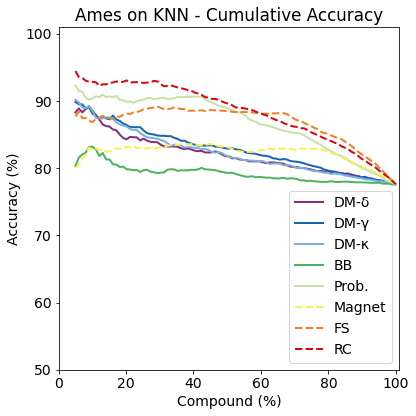

In [7]:
def plot_ca(clf, clf_alias, dataset, path_output, figsize=(6,6), fontsize=14):
    """Plot Cumulative Accuracy plot"""
    plt.rc("figure", autolayout=True, figsize=figsize)
    plt.rcParams["font.size"] = fontsize

    fig, ax = plt.subplots()

    df = get_df_ca(clf, dataset)
    for i, ad in enumerate(df.columns[1:]):
        # Dashed lines for all advx. defenses
        ls = '--' if ad in AL else '-'
        ax.plot(df[df.columns[0]], 
                df[ad], 
                alpha=1, 
                lw=2, 
                color=COLOURS[i], 
                ls=ls, 
                label=ad,
        )

    ax.set(xlim=[0., 101], ylim=[50., 101.])
    ax.legend(loc="lower right")
    ax.set_xlabel('Compound (%)')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'{dataset} on {clf_alias} - Cumulative Accuracy')
    plt.tight_layout()
    plt.savefig(path_output, dpi=300)

# Test function
path_test = os.path.join(PATH_ROOT, 'plot_results', 'ames_knn_ca.pdf')
plot_ca(CLASSIFIERS[0], CLF_alias[0], DATASETS[0], path_test)
os.remove(path_test)

/tmp/ipykernel_32971/274504231.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


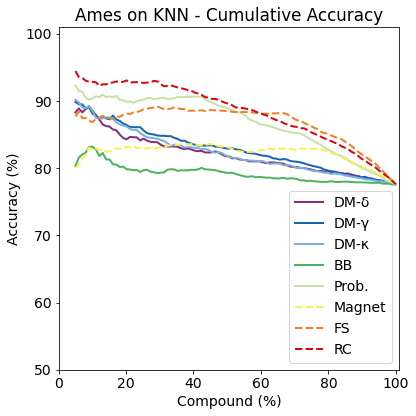

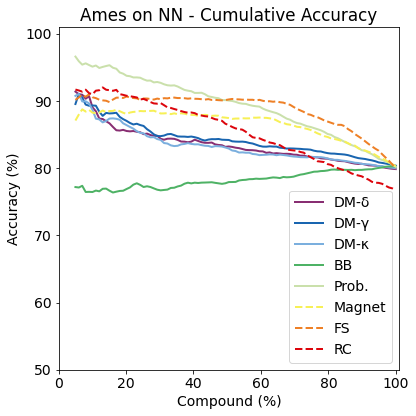

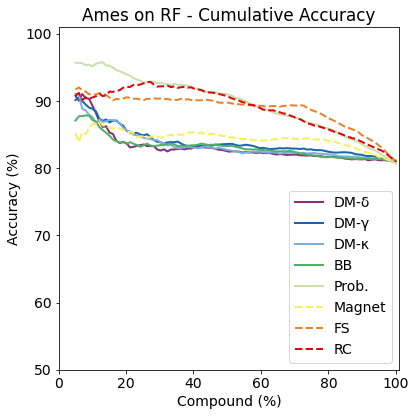

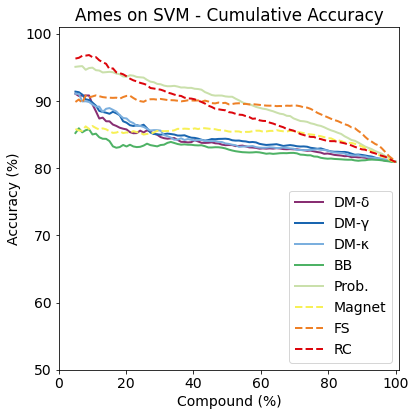

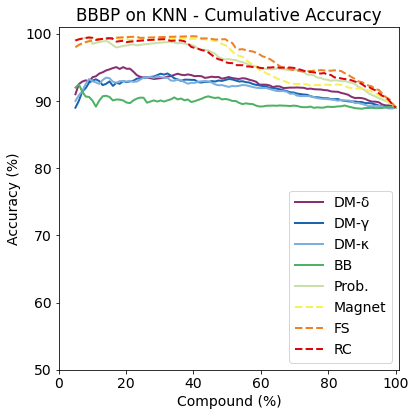

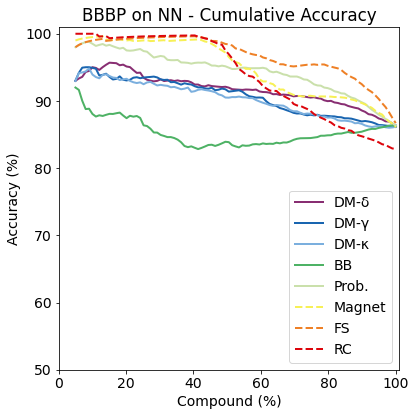

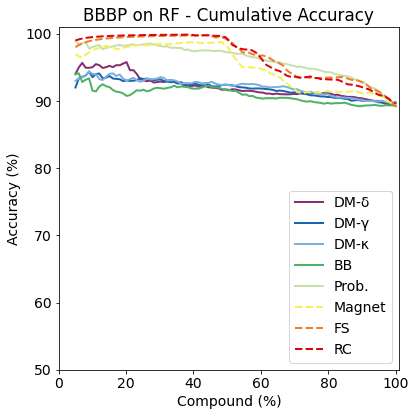

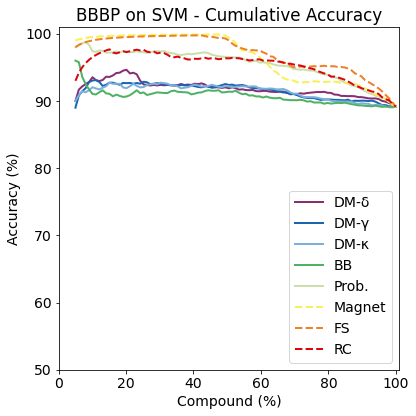

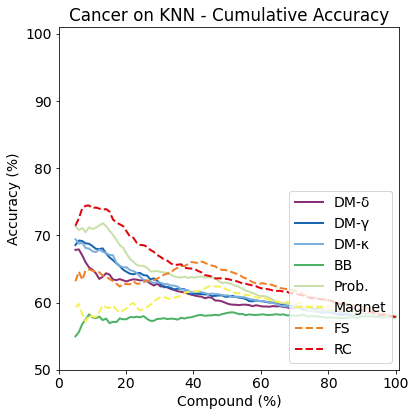

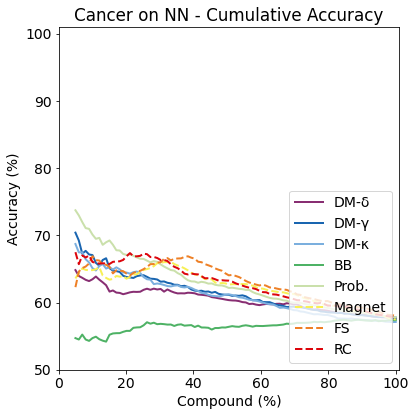

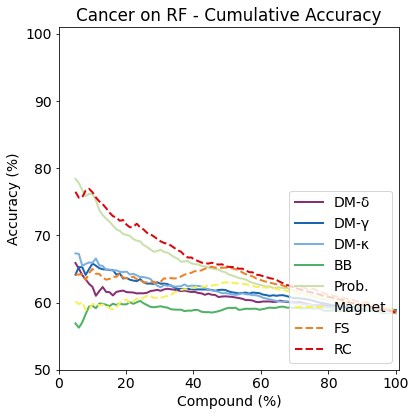

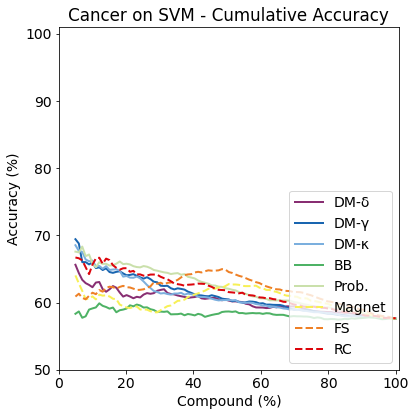

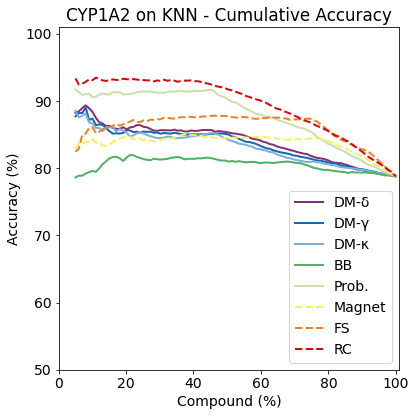

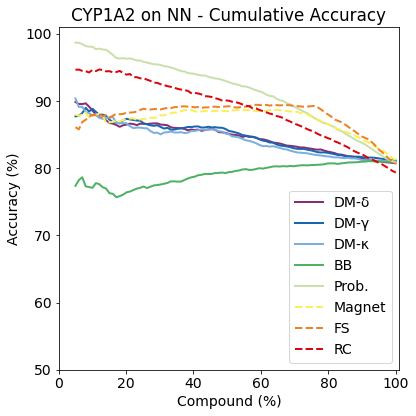

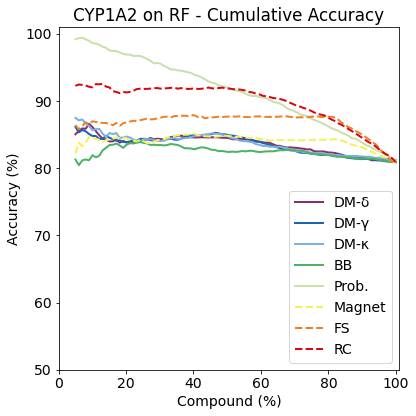

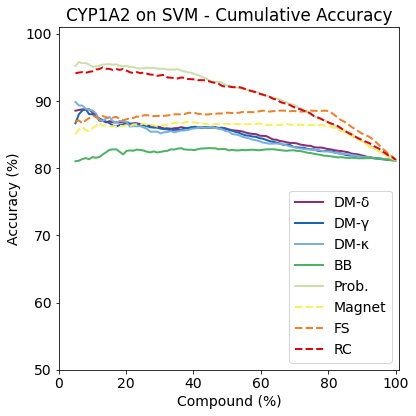

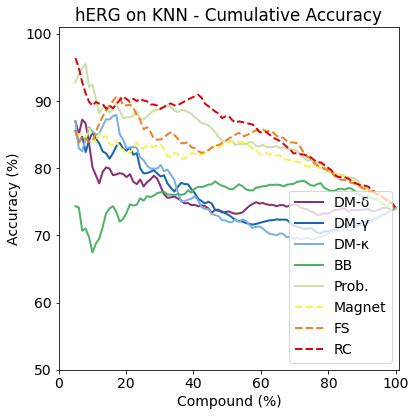

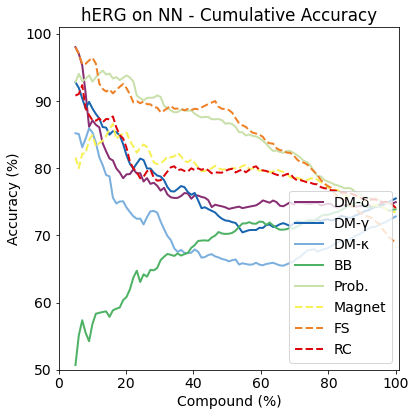

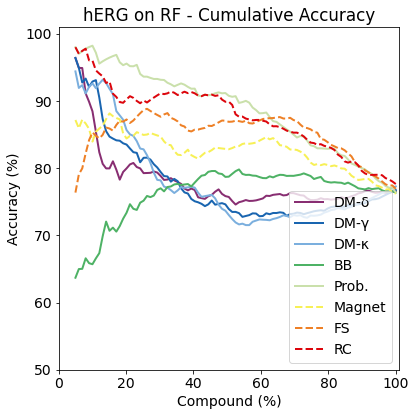

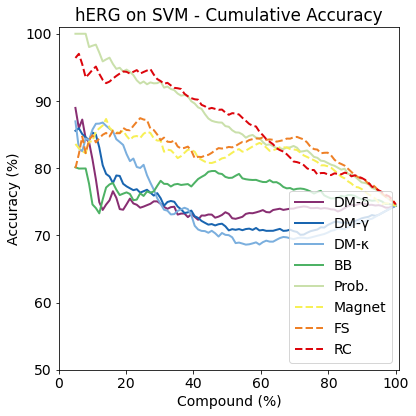

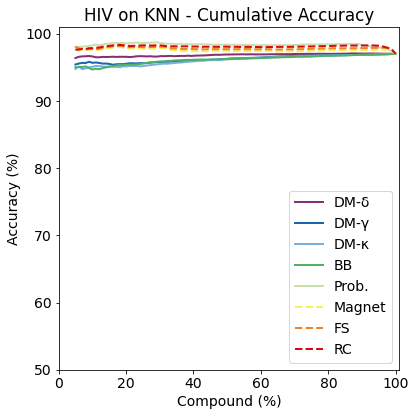

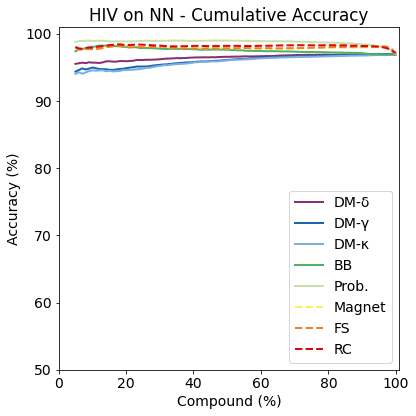

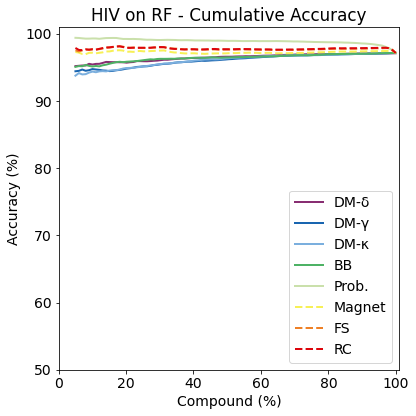

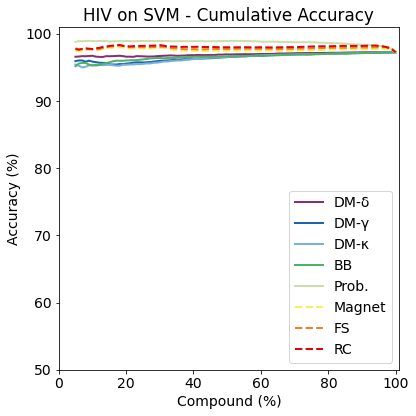

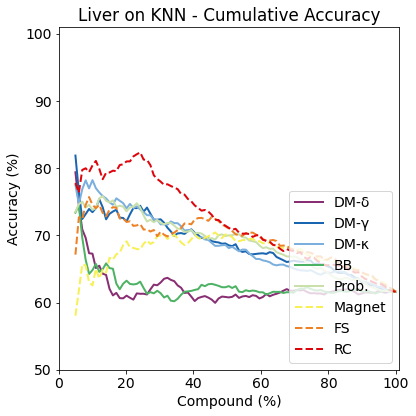

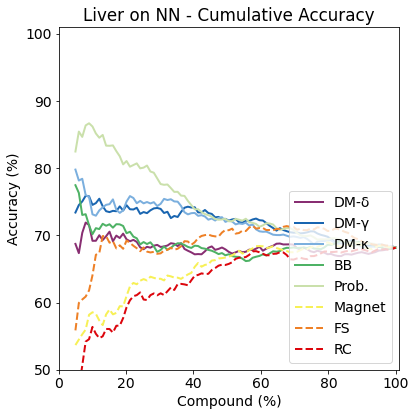

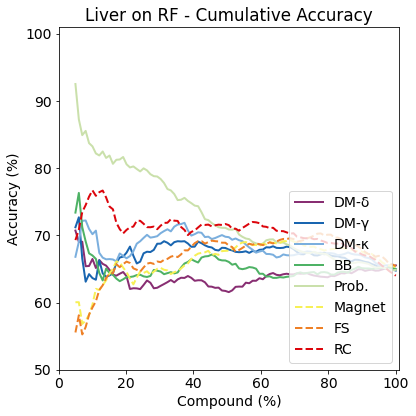

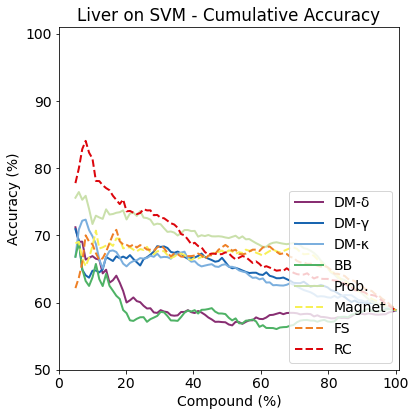

In [8]:
path_roc = Path(os.path.join(PATH_ROOT, 'plot_results', 'cumulative_acc'))
for dataset in DATASETS:
    for clf, alias in zip(CLASSIFIERS, CLF_alias):
        plot_ca(clf, alias, dataset, path_roc / f'{dataset}_{alias}_ca.pdf')